# 🧼 Data Preprocessing Techniques

This notebook reviews essential **data preprocessing** techniques, a key stage in any data science or machine learning project.

> The goal is to prepare data for machine learning models to run efficiently and accurately.


## Example data

### 1. Importing libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer # to handle missing values

### 2. Loading example data

In [2]:
# Create an example Dataframe (very simple)
data = pd.DataFrame({
    'Age': [25, 27, np.nan, 35, 29],
    'Salary': [50000, 54000, 58000, np.nan, 62000],
    'City': ['Madrid', 'Barcelona', 'Madrid', 'Valencia', np.nan]
})

data

,Age,Salary,City
0,25.0,50000.0,Madrid
1,27.0,54000.0,Barcelona
2,NaN,58000.0,Madrid
3,35.0,NaN,Valencia
4,29.0,62000.0,NaN


### 3. Handling missing values

Missing values can bias results or cause models to fail. Two different strategies are:
- Remove rows/columns with many missing values
- Impute (fill in) using the mean, median, mode, or specific values

In [3]:
# First numeric fields (we'll deal with categorical variables later)
imputer = SimpleImputer(strategy='mean')
data[['Age', 'Salary']] = imputer.fit_transform(data[['Age', 'Salary']])
data

,Age,Salary,City
0,25.0,50000.0,Madrid
1,27.0,54000.0,Barcelona
2,29.0,58000.0,Madrid
3,35.0,56000.0,Valencia
4,29.0,62000.0,NaN


### 4. Encoding Categorical Data

However, categorical variables must be transformed into numbers for most machine learning algorithms. Two options are:

- Label Encoding: we replace each class with numerical values from 0 to the number of classes minus 1
- One-Hot Encoding: we create as many fields as there are distinct values


In [4]:
# One-hot encode the column 'City'
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Compressed by default (sparse_output = True)
encoded = encoder.fit_transform(data[['City']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['City']))

# Update the column in the original dataset
data_encoded = data.drop('City', axis=1).join(encoded_df)
data_encoded

,Age,Salary,City_Barcelona,City_Madrid,City_Valencia,City_nan
0,25.0,50000.0,0.0,1.0,0.0,0.0
1,27.0,54000.0,1.0,0.0,0.0,0.0
2,29.0,58000.0,0.0,1.0,0.0,0.0
3,35.0,56000.0,0.0,0.0,1.0,0.0
4,29.0,62000.0,0.0,0.0,0.0,1.0


For categorical variables with many levels, consider techniques like target encoding or embedding:

- Target Encoding: replace each category with the mean of the target variable for that category
- Embedding: map each category to a dense, learnable vector during training

### 5. Feature Scaling

Many ML techniques are affected by the scale of the data (e.g., KNN or logistic regression). Therefore, it is useful to scale numerical variables. The two most common methods are:

- `StandardScaler`: mean 0, variance 1 (z-score normalization)
- `MinMaxScaler`: values between 0 and 1


In [5]:
# Standardization (z-score normalization)
scaler = StandardScaler()
data_encoded[['Age', 'Salary']] = scaler.fit_transform(data_encoded[['Age', 'Salary']])

# Min-max scaling
minmax = MinMaxScaler()
data_minmax = data_encoded.copy()
data_minmax[['Age', 'Salary']] = minmax.fit_transform(data_encoded[['Age', 'Salary']])

data_encoded
# data_minmax

,Age,Salary,City_Barcelona,City_Madrid,City_Valencia,City_nan
0,-1.195229,-1.5,0.0,1.0,0.0,0.0
1,-0.597614,-0.5,1.0,0.0,0.0,0.0
2,0.000000,0.5,0.0,1.0,0.0,0.0
3,1.792843,0.0,0.0,0.0,1.0,0.0
4,0.000000,1.5,0.0,0.0,0.0,1.0


## Data Preprocessing Techniques with Real Data

Next, we will follow the same steps on a real dataset. For this, we will use the Titanic passengers dataset, which contains data such as age, social class, gender, etc.

> The goal is to apply the necessary transformations so that ML models can correctly understand and process the information.


In [6]:
# Libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns  # to load dataset and display it
import matplotlib.pyplot as plt

# Functions for preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
# Load the Titanic dataset from Seaborn (available datasets: https://github.com/mwaskom/seaborn-data)
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [8]:
# 0. First check of the dataset
# Examine the dimensions and data types
print("Dimensions: ",df.shape)
print("Data types: \n",df.dtypes)

# Check how many missing values there are per column
df.isnull().sum()

Dimensions:  (891, 15)
Data types: 
 survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


> There are columns with many missing values, such as `deck`, while others have some, like `age` and `embarked`.


In [9]:
# 1. Separate numerical and categorical variables

# Select the most useful or interesting columns
df_model = df[['survived', 'pclass', 'sex', 'age', 'embarked']].copy() # Create an independent copy of df

# Identify numerical and categorical variables
numerical_features = ['age']
categorical_features = ['pclass', 'sex', 'embarked']

In [10]:
# 2. Define transformations for each data type (as they require different treatments)
# This time, for cleanliness, we will apply the transformations simultaneously using the `sklearn.pipeline` function

# Numerical value imputation + scaling
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # replace nulls with median
    ('scaler', StandardScaler())                    # standardize the scale
])

# Categorical value imputation + one-hot enconding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   # the mode (most common value)
    ('encoder', OneHotEncoder(handle_unknown='ignore'))     # one-hot for text
])

In [11]:
# 3. Combine all with sklearn.compose

# Apply different transformations to each type of column
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [12]:
# 4. Apply preprocessing
X = df_model.drop('survived', axis=1)
y = df_model['survived'] # This is the target, which we will not apply transformations to (already 1's and 0's)

X_preprocessed = preprocessor.fit_transform(X)

# Convert the result to a DataFrame for visualization
X_preprocessed_df = pd.DataFrame(
    X_preprocessed,
    columns=preprocessor.get_feature_names_out())

X_preprocessed_df.head()

,num__age,cat__pclass_1,cat__pclass_2,cat__pclass_3,cat__sex_female,cat__sex_male,cat__embarked_C,cat__embarked_Q,cat__embarked_S
0,-0.565736,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.663861,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.258337,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.433312,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.433312,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### ✅ Summary (from the Titanic example):

- How to load real data with missing values and mixed types
- How to build preprocessing pipelines with `scikit-learn`
- The importance of separating transformations for numerical and categorical data
- Applying `ColumnTransformer` and `Pipeline` to organize the cleaning workflow

This type of workflow is very common in real pipelines, especially when working with `sklearn`, `MLFlow`, or production environments.

> IMPORTANT: Always split your data into train and test sets before preprocessing to avoid data leakage.


## (APPENDIX A) Exploratory Data Analysis (EDA)

Before any transformation or modeling, it is essential to **understand the dataset**: its structure, patterns, outliers, missing data, and distributions.

Therefore, we will continue with a deeper analysis of the dataset:

1. General information about the dataset
2. Analysis of missing values
3. Basic statistics
4. Variable distributions
5. Key correlations and relationships

> Note: Next notebook is related to EDA with Pandas and Matplotlib. However, this appendix covers a quick preview of EDA using seaborn visualizations ([Next Notebook](https://colab.research.google.com/drive/1xdStpoMONZ334vKTdnLNV7WQ_HYoLjvm?usp=sharing)).

In [13]:
# 1. General info

# Number of rows and cols
print(f"Dimensions: {df.shape}")

# More complete info: cols, data types and non-null count
df.info()

Dimensions: (891, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,0
deck,688
age,177
embarked,2
embark_town,2
sex,0
pclass,0
survived,0
fare,0
parch,0
sibsp,0


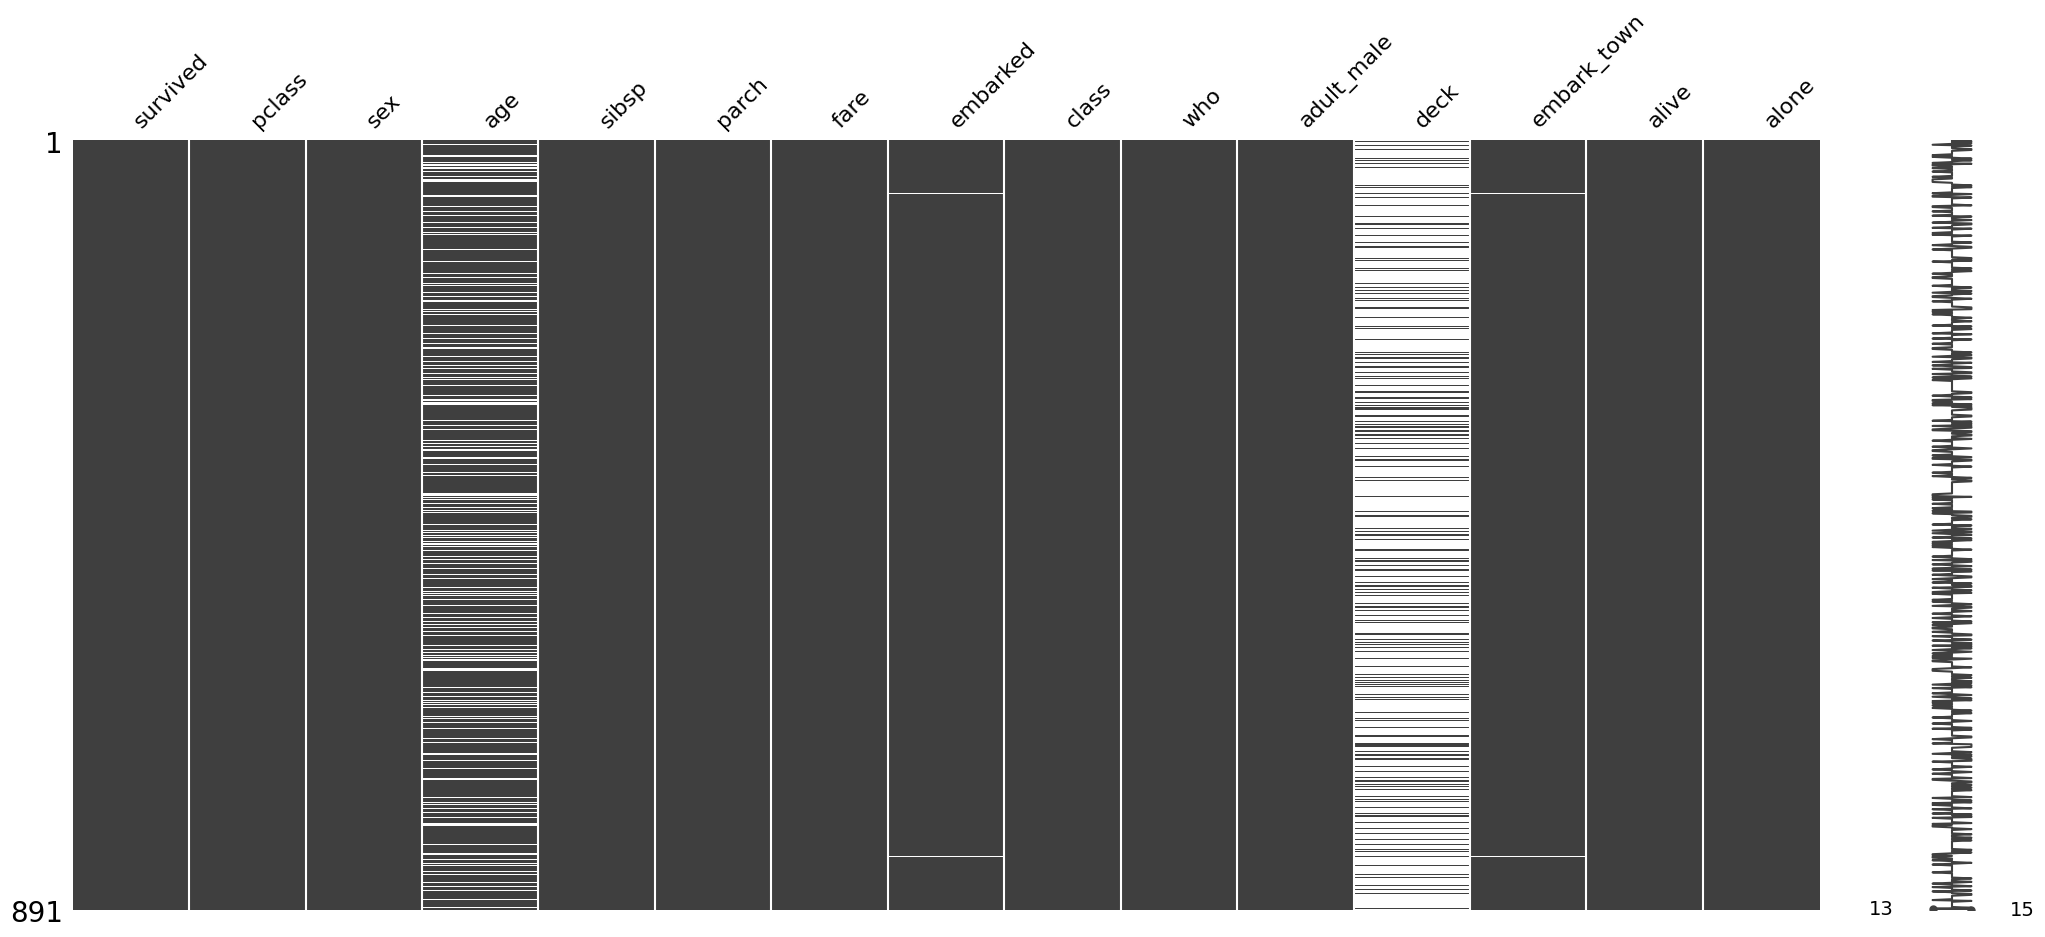

In [14]:
# 2. Missing values

import missingno as msno # Specific library for handleling missing values

# Quick view of null per column
msno.matrix(df)

# Total number of null values (ordered)
df.isnull().sum().sort_values(ascending=False)

In [15]:
# 3. Basic stats

# Numerical variables
# Shown: count, mean, desvest, min, max and quartiles
df.describe() # int and float vars by default

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
# Categorical variables
# Shown: count, distinct values, mode, max freq
df.describe(include='object')

,sex,embarked,who,embark_town,alive
count,891,889,891,889,891
unique,2,3,3,3,2
top,male,S,man,Southampton,no
freq,577,644,537,644,549


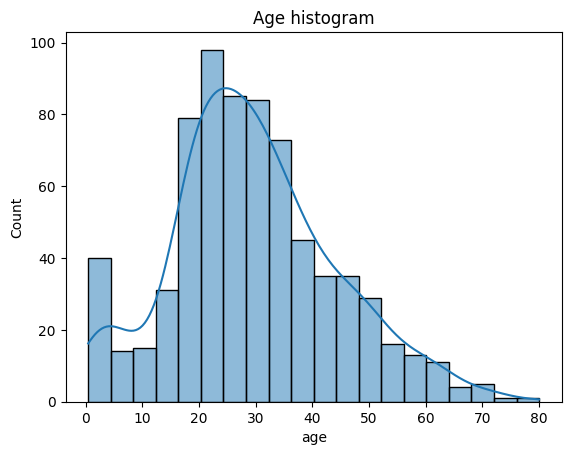

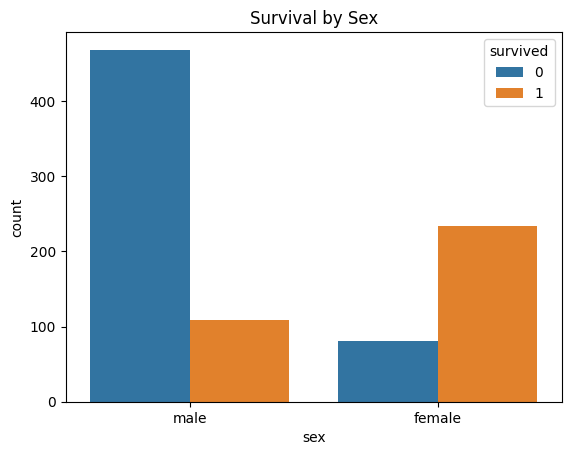

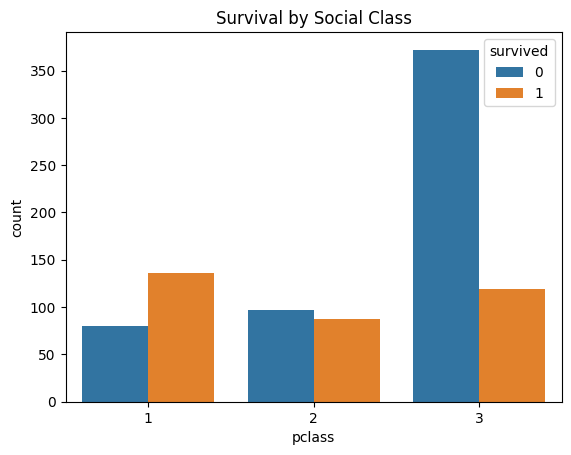

In [17]:
# 4. Important distributions (Titanic dataset)

# Age distribution as a histogram (shows the freq distribution of a variable)
sns.histplot(df['age'], kde=True) # kde: adds a smothed line
plt.title('Age histogram')
plt.show()

# Survival by sex as a countplot (shows a freq distribution based on another variable)
sns.countplot(data=df, x='sex', hue='survived')
plt.title('Survival by Sex')
plt.show()

# Survival by class
sns.countplot(data=df, x='pclass', hue='survived')
plt.title('Survival by Social Class')
plt.show()

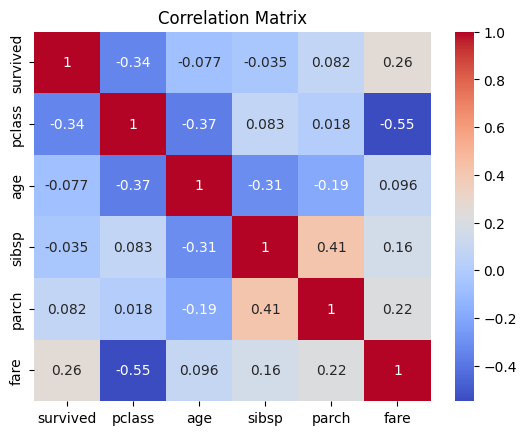

In [18]:
# 5. Correlations between numerical variables

# Correlation matrix (shows relationships between multiple variables)
correlation = df.select_dtypes(include='number').corr()

# Heatmap of correlations
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

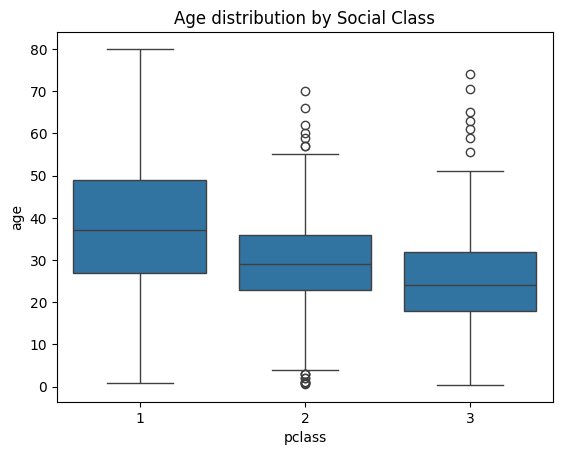

In [19]:
# 6. Other seaborn options include:
# Boxplots to visualize outliers by group
# Pairplots to explore relationships between multiple variables
# Violin plots to show both distribution and density together

# Functions:
# pivot_table() to create pivot tables between variables
# value_counts() to display category frequencies

# Boxplot: age by class
sns.boxplot(data=df, x='pclass', y='age')
plt.title('Age distribution by Social Class')
plt.show()